In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Kepler_dataset.csv")

X = df.drop(columns=["kepid", "target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[201  61   9]
 [ 39 502   2]
 [  1   2 743]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.79       271
           1       0.89      0.92      0.91       543
           2       0.99      1.00      0.99       746

    accuracy                           0.93      1560
   macro avg       0.90      0.89      0.89      1560
weighted avg       0.93      0.93      0.93      1560



In [4]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.84      0.81      0.83       271
           1       0.91      0.92      0.91       543
           2       1.00      1.00      1.00       746

    accuracy                           0.94      1560
   macro avg       0.92      0.91      0.91      1560
weighted avg       0.94      0.94      0.94      1560



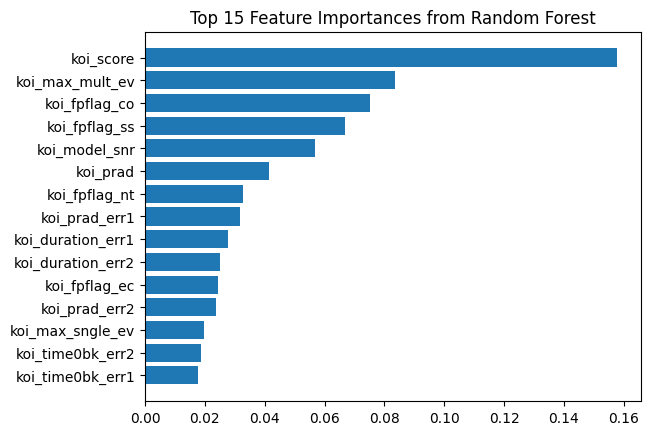

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Feature Importances from Random Forest")
plt.show()


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=12)),
        ("xgb", XGBClassifier(n_estimators=500, max_depth=8))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

from sklearn.metrics import accuracy_score

stack.fit(X_train_scaled, y_train)
y_pred_stack = stack.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_stack)
print(classification_report(y_test, y_pred_stack))
print(f"Accuracy del stacking: {accuracy:.4f}")

stack.feature_names_in_ = X.columns.tolist()


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       271
           1       0.90      0.92      0.91       543
           2       1.00      1.00      1.00       746

    accuracy                           0.94      1560
   macro avg       0.91      0.91      0.91      1560
weighted avg       0.94      0.94      0.94      1560



In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=12)),
        ("xgb", XGBClassifier(n_estimators=500, max_depth=8))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stack.fit(X_train_scaled, y_train)
y_pred_stack = stack.predict(X_test_scaled)
print(classification_report(y_test, y_pred_stack))


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       271
           1       0.90      0.92      0.91       543
           2       1.00      1.00      1.00       746

    accuracy                           0.94      1560
   macro avg       0.91      0.91      0.91      1560
weighted avg       0.94      0.94      0.94      1560



In [ ]:
import joblib

model_accuracy = accuracy

stack.feature_names_in_ = X.columns.tolist()
stack.accuracy_ = model_accuracy

joblib.dump(stack, "kepler_stacking_classifier.pkl")
joblib.dump(scaler, "k2_scaler.pkl")

print(f"Modelo guardado correctamente (accuracy = {model_accuracy:.4f})")


['k2_scaler.pkl']